<a href="https://colab.research.google.com/github/hashPhoeNiX/ColabNotebooks/blob/master/PHM_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Dataset folder: https://drive.google.com/drive/folders/1I4sweKPWtAeuL9vxFeLTbfeL8s-rcbz8?usp=sharing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import keras as k
from sklearn import preprocessing
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, merge, Input, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adadelta, Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from sklearn.metrics import mean_squared_error 
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import load_model
from sklearn.metrics import mean_squared_error

In [ ]:
import os
import glob
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Untitled folder/PHM DATA SET')

In [ ]:
train_paths = 'DATA SET/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-data/training'
test_paths = 'DATA SET/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-data/test'

In [ ]:
train_files = [i for i in glob.glob(train_paths + '/' + '*.csv')]
test_files = [i for i in glob.glob(test_paths + '/' + '*.csv')]
 
len(train_files), len(test_files)

(185, 185)

In [ ]:
train_combined = pd.concat([pd.read_csv(f) for f in train_files])
test_combined = pd.concat([pd.read_csv(f) for f in test_files])

In [ ]:
train_label = pd.read_csv('./DATA SET/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-training-removalrate.csv')
test_label = pd.read_csv('./DATA SET/2016 PHM DATA CHALLENGE CMP DATA SET/orig_CMP-test-removalrate.csv')

In [ ]:
train_label.head()

,WAFER_ID,STAGE,AVG_REMOVAL_RATE
0,-4224160600,A,61.65480
1,-4224160584,B,75.86415
2,-4224160580,B,71.90700
3,-4113511818,A,65.02230
4,-4113511814,A,58.27905


In [ ]:
test_label.head()

,WAFER_ID,STAGE,AVG_REMOVAL_RATE
0,-4224160678,B,66.9813
1,-4224160592,A,56.1786
2,-887170152,B,64.3881
3,373446766,A,153.2610
4,-4224160686,A,57.2523


In [ ]:
train = pd.merge(train_combined, train_label, on=['WAFER_ID', 'STAGE'], how='inner')
test = pd.merge(test_combined, test_label, on=['WAFER_ID', 'STAGE'], how='inner')

In [ ]:
train.shape, test.shape

((671422, 26), (156262, 26))

In [ ]:
# Detecting Outliers Train
train['AVG_REMOVAL_RATE'].describe()

count    672744.000000
mean         95.821890
std         184.589539
min          53.426550
25%          72.117750
50%          78.318900
75%          87.109950
max        4326.154050
Name: AVG_REMOVAL_RATE, dtype: float64

In [ ]:
train = train[train['AVG_REMOVAL_RATE'] <= 3000]

In [ ]:
len(train), len(test)

(671422, 156262)

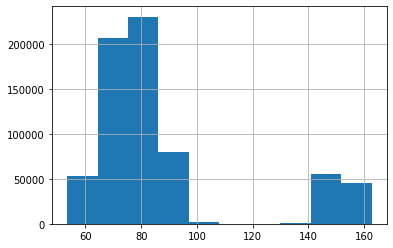

In [ ]:
train['AVG_REMOVAL_RATE'].hist()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671422 entries, 0 to 672743
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   MACHINE_ID                    671422 non-null  object 
 1   MACHINE_DATA                  671422 non-null  object 
 2   TIMESTAMP                     671422 non-null  float64
 3   WAFER_ID                      671422 non-null  object 
 4   STAGE                         671422 non-null  object 
 5   CHAMBER                       671422 non-null  float64
 6   USAGE_OF_BACKING_FILM         671422 non-null  float64
 7   USAGE_OF_DRESSER              671422 non-null  float64
 8   USAGE_OF_POLISHING_TABLE      671422 non-null  float64
 9   USAGE_OF_DRESSER_TABLE        671422 non-null  float64
 10  PRESSURIZED_CHAMBER_PRESSURE  671422 non-null  float64
 11  MAIN_OUTER_AIR_BAG_PRESSURE   671422 non-null  float64
 12  CENTER_AIR_BAG_PRESSURE       671422 non-nul

In [ ]:
# Splitting Train Data into Two based on CHAMBERS
 
train_120u = train[train['CHAMBER'] <= 3]
train_120d = train[train['CHAMBER'] >= 4]
 
# Splitting Test Data
test_120u = test[test['CHAMBER'] <= 3]
test_120d = test[test['CHAMBER'] >= 4]

In [ ]:
# Rolling apply function 
 
def roll(df):
  """ Feature Engineering """
  df = df.sort_values(by=['TIMESTAMP'])
  columns = [i for i in df.columns if i != 'AVG_REMOVAL_RATE'][5:]
  for col in columns:
    df['rolling_mean_'+col] = df.groupby(['WAFER_ID', 'STAGE'])[col].rolling(10).mean().reset_index(drop=True)
    df['rolling_median_'+col] = df.groupby(['WAFER_ID', 'STAGE'])[col].rolling(10).median().reset_index(drop=True)
    df['rolling_std_'+col] = df.groupby(['WAFER_ID', 'STAGE'])[col].rolling(10).std().reset_index(drop=True)
    # df['sd0_'+col] = pd.Series([sd for sd in df['rolling_std_'+col].values if sd >= 0])
    print("Column {} done!".format(col))
  
  df.dropna(axis=0, inplace=True)
  print('Complete!!!')
 
  return df

## 120D

In [ ]:
train_120d = pd.get_dummies(train_120d, columns=['CHAMBER'])
test_120d = pd.get_dummies(test_120d, columns=['CHAMBER'])

In [ ]:
len(train_120d), len(test_120d)

(570023, 136265)

In [ ]:
train_120d = roll(train_120d)

Column USAGE_OF_BACKING_FILM done!
Column USAGE_OF_DRESSER done!
Column USAGE_OF_POLISHING_TABLE done!
Column USAGE_OF_DRESSER_TABLE done!
Column PRESSURIZED_CHAMBER_PRESSURE done!
Column MAIN_OUTER_AIR_BAG_PRESSURE done!
Column CENTER_AIR_BAG_PRESSURE done!
Column RETAINER_RING_PRESSURE done!
Column RIPPLE_AIR_BAG_PRESSURE done!
Column USAGE_OF_MEMBRANE done!
Column USAGE_OF_PRESSURIZED_SHEET done!
Column SLURRY_FLOW_LINE_A done!
Column SLURRY_FLOW_LINE_B done!
Column SLURRY_FLOW_LINE_C done!
Column WAFER_ROTATION done!
Column STAGE_ROTATION done!
Column HEAD_ROTATION done!
Column DRESSING_WATER_STATUS done!
Column EDGE_AIR_BAG_PRESSURE done!
Column CHAMBER_4.0 done!
Column CHAMBER_5.0 done!
Column CHAMBER_6.0 done!
Complete!!!


In [ ]:
test_120d = roll(test_120d)

Column USAGE_OF_BACKING_FILM done!
Column USAGE_OF_DRESSER done!
Column USAGE_OF_POLISHING_TABLE done!
Column USAGE_OF_DRESSER_TABLE done!
Column PRESSURIZED_CHAMBER_PRESSURE done!
Column MAIN_OUTER_AIR_BAG_PRESSURE done!
Column CENTER_AIR_BAG_PRESSURE done!
Column RETAINER_RING_PRESSURE done!
Column RIPPLE_AIR_BAG_PRESSURE done!
Column USAGE_OF_MEMBRANE done!
Column USAGE_OF_PRESSURIZED_SHEET done!
Column SLURRY_FLOW_LINE_A done!
Column SLURRY_FLOW_LINE_B done!
Column SLURRY_FLOW_LINE_C done!
Column WAFER_ROTATION done!
Column STAGE_ROTATION done!
Column HEAD_ROTATION done!
Column DRESSING_WATER_STATUS done!
Column EDGE_AIR_BAG_PRESSURE done!
Column CHAMBER_4.0 done!
Column CHAMBER_5.0 done!
Column CHAMBER_6.0 done!
Complete!!!


In [ ]:
test_120d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116800 entries, 281 to 136264
Data columns (total 94 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   MACHINE_ID                                   116800 non-null  object 
 1   MACHINE_DATA                                 116800 non-null  object 
 2   TIMESTAMP                                    116800 non-null  float64
 3   WAFER_ID                                     116800 non-null  object 
 4   STAGE                                        116800 non-null  object 
 5   USAGE_OF_BACKING_FILM                        116800 non-null  float64
 6   USAGE_OF_DRESSER                             116800 non-null  float64
 7   USAGE_OF_POLISHING_TABLE                     116800 non-null  float64
 8   USAGE_OF_DRESSER_TABLE                       116800 non-null  float64
 9   PRESSURIZED_CHAMBER_PRESSURE                 116800 non-n

In [ ]:
len(train_120d), len(test_120d)

(470265, 116800)

In [ ]:

# to be used later while saving predictions 

wafer_120d = test_120d['WAFER_ID']
stage_120d = test_120d['STAGE']

### Feature scaling and Model training

In [ ]:
train_120d.shape

(470265, 94)

In [ ]:
test_120d.shape

(116800, 94)

In [ ]:
label_train = train_120d['AVG_REMOVAL_RATE']
train_120d = train_120d.drop(['AVG_REMOVAL_RATE', 'STAGE', 'TIMESTAMP'], axis=1)
 
label_test = test_120d['AVG_REMOVAL_RATE']
test_120d = test_120d.drop(['AVG_REMOVAL_RATE', 'STAGE', 'TIMESTAMP'], axis=1)

In [ ]:
train_120d = train_120d.to_numpy()
test_120d = test_120d.to_numpy()

In [ ]:
def feature_scaling(train_df, test_df):
    """ Feature Scaling """
    train_df = np.reshape(train_df,(train_df.shape[0], train_df.shape[1]))
    a= np.zeros((train_df.shape[0], 1))
    for i in range(train_df.shape[1]):
        X_scaled = preprocessing.scale(train_df[:,i])
        X_scaled = np.reshape(X_scaled,(train_df.shape[0],1))
        a = np.hstack((a,X_scaled))
    train_df = np.delete(a, (0), axis=1)
 
 
    test_df = np.reshape(test_df,(test_df.shape[0], test_df.shape[1]))
    a= np.zeros((test_df.shape[0], 1))
    for i in range(test_df.shape[1]):
        X_scaled = preprocessing.scale(test_df[:,i])
        X_scaled = np.reshape(X_scaled,(test_df.shape[0], 1))
        a = np.hstack((a,X_scaled))
    test_df = np.delete(a, (0), axis=1)
    
    return train_df, test_df

In [ ]:
train_120d, test_120d = feature_scaling(train_120d, test_120d)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
test_120d.shape

(116800, 91)

In [ ]:
test_120d.dtype

dtype('float64')

# Model Training

In [ ]:
# define rmse loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
 
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(91, input_dim=91, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model  
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', root_mean_squared_error])
    
    return model

### train_120d model training and evaluation on test_120d

In [ ]:
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=20, batch_size=15, verbose=2)
 
results = cross_val_score(estimator, train_120d, label_train, cv=2)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/20
 - 51s - loss: 114.2674 - mse: 114.2676 - root_mean_squared_error: 7.5706
Epoch 2/20
 - 51s - loss: 30.5633 - mse: 30.5633 - root_mean_squared_error: 5.4221
Epoch 3/20
 - 52s - loss: 27.4203 - mse: 27.4202 - root_mean_squared_error: 5.1336
Epoch 4/20
 - 51s - loss: 25.2094 - mse: 25.2094 - root_mean_squared_error: 4.9199
Epoch 5/20
 - 51s - loss: 23.5248 - mse: 23.5248 - root_mean_squared_error: 4.7525
Epoch 6/20
 - 50s - loss: 22.4805 - mse: 22.4805 - root_mean_squared_error: 4.6444
Epoch 7/20
 - 50s - loss: 21.7735 - mse: 21.7735 - root_mean_squared_error: 4.5702
Epoch 8/20
 - 50s - loss: 20.9526 - mse: 20.9526 - root_mean_squared_error: 4.4828
Epoch 9/20
 - 51s - loss: 19.8088 - mse: 19.8088 - root_mean_squared_error: 4.3586
Epoch 10/20
 - 51s - loss: 18.9594 - mse: 18.9594 - root_mean_squared_error: 4.2637
Epoch 11/20
 - 51s - loss: 18.1844 - mse: 18.1844 - root_mean_squared_error: 4.1753
Epoch 12/20
 - 51s - loss: 17.3211 - mse: 17.3211 - root_mean_squared_error: 4.0737

In [ ]:
# Fitting the model and Predicting on the test set
 
estimator.fit(train_120d, label_train)
prediction = estimator.predict(test_120d)
 
# estimator.model.save('saved_model.h5')
print("MSE: ", mean_squared_error(label_test, prediction))
print("RMSE: ", mean_squared_error(label_test, prediction, squared=False))

Epoch 1/20
 - 101s - loss: 70.7152 - mse: 70.7154 - root_mean_squared_error: 6.4601
Epoch 2/20
 - 100s - loss: 26.3166 - mse: 26.3166 - root_mean_squared_error: 5.0217
Epoch 3/20
 - 101s - loss: 23.7156 - mse: 23.7157 - root_mean_squared_error: 4.7642
Epoch 4/20
 - 100s - loss: 22.1886 - mse: 22.1885 - root_mean_squared_error: 4.6096
Epoch 5/20
 - 100s - loss: 20.8939 - mse: 20.8939 - root_mean_squared_error: 4.4691
Epoch 6/20
 - 101s - loss: 19.8686 - mse: 19.8687 - root_mean_squared_error: 4.3391
Epoch 7/20
 - 100s - loss: 19.0705 - mse: 19.0705 - root_mean_squared_error: 4.2027
Epoch 8/20
 - 101s - loss: 17.7293 - mse: 17.7293 - root_mean_squared_error: 4.0954
Epoch 9/20
 - 102s - loss: 17.2004 - mse: 17.2004 - root_mean_squared_error: 4.0253
Epoch 10/20
 - 101s - loss: 16.6529 - mse: 16.6530 - root_mean_squared_error: 3.9550
Epoch 11/20
 - 100s - loss: 16.0972 - mse: 16.0972 - root_mean_squared_error: 3.8871
Epoch 12/20
 - 102s - loss: 15.7434 - mse: 15.7433 - root_mean_squared_err

In [ ]:
# loading the model
model2 = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=10, verbose=1)
 
dependencies = {
    'root_mean_squared_error': root_mean_squared_error
}
model2.model = load_model('saved_model.h5', custom_objects=dependencies)
 
pred_d = model2.predict(test_120d)
print("MSE: ", mean_squared_error(label_test, pred_d))
print("RMSE: ", mean_squared_error(label_test, pred_d, squared=False))

116800/116800 [==============================] - 11s 90us/step
MSE:  80.61512986636775
RMSE:  8.978592866722924


In [ ]:
train_d_pred = model2.predict(train_120d)
test_d_pred = model2.predict(test_120d)
print("train_120d RMSE: ", mean_squared_error(label_train, train_d_pred, squared=False)) 
print("test_120d RMSE: ", mean_squared_error(label_test, test_d_pred, squared=False))

116800/116800 [==============================] - 10s 90us/step
train_120d RMSE:  3.655166256475171
test_120d RMSE:  8.978592866722924


In [ ]:
# saving predictions 
 
np.save('nn_d_best',pred_d)

## 120U

In [ ]:
train_120u = pd.get_dummies(train_120u, columns=['CHAMBER'])
test_120u = pd.get_dummies(test_120u, columns=['CHAMBER'])

In [ ]:
len(train_120u), len(test_120u)

(101399, 19997)

In [ ]:
# rolling apply function
 
train_120u = roll(train_120u)

Column USAGE_OF_BACKING_FILM done!
Column USAGE_OF_DRESSER done!
Column USAGE_OF_POLISHING_TABLE done!
Column USAGE_OF_DRESSER_TABLE done!
Column PRESSURIZED_CHAMBER_PRESSURE done!
Column MAIN_OUTER_AIR_BAG_PRESSURE done!
Column CENTER_AIR_BAG_PRESSURE done!
Column RETAINER_RING_PRESSURE done!
Column RIPPLE_AIR_BAG_PRESSURE done!
Column USAGE_OF_MEMBRANE done!
Column USAGE_OF_PRESSURIZED_SHEET done!
Column SLURRY_FLOW_LINE_A done!
Column SLURRY_FLOW_LINE_B done!
Column SLURRY_FLOW_LINE_C done!
Column WAFER_ROTATION done!
Column STAGE_ROTATION done!
Column HEAD_ROTATION done!
Column DRESSING_WATER_STATUS done!
Column EDGE_AIR_BAG_PRESSURE done!
Column CHAMBER_1.0 done!
Column CHAMBER_2.0 done!
Column CHAMBER_3.0 done!
Complete!!!


In [ ]:
 test_120u = roll(test_120u)

Column USAGE_OF_BACKING_FILM done!
Column USAGE_OF_DRESSER done!
Column USAGE_OF_POLISHING_TABLE done!
Column USAGE_OF_DRESSER_TABLE done!
Column PRESSURIZED_CHAMBER_PRESSURE done!
Column MAIN_OUTER_AIR_BAG_PRESSURE done!
Column CENTER_AIR_BAG_PRESSURE done!
Column RETAINER_RING_PRESSURE done!
Column RIPPLE_AIR_BAG_PRESSURE done!
Column USAGE_OF_MEMBRANE done!
Column USAGE_OF_PRESSURIZED_SHEET done!
Column SLURRY_FLOW_LINE_A done!
Column SLURRY_FLOW_LINE_B done!
Column SLURRY_FLOW_LINE_C done!
Column WAFER_ROTATION done!
Column STAGE_ROTATION done!
Column HEAD_ROTATION done!
Column DRESSING_WATER_STATUS done!
Column EDGE_AIR_BAG_PRESSURE done!
Column CHAMBER_1.0 done!
Column CHAMBER_2.0 done!
Column CHAMBER_3.0 done!
Complete!!!


In [ ]:
train_120u.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16877 entries, 9246 to 94606
Data columns (total 94 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   MACHINE_ID                                   16877 non-null  object 
 1   MACHINE_DATA                                 16877 non-null  object 
 2   TIMESTAMP                                    16877 non-null  float64
 3   WAFER_ID                                     16877 non-null  object 
 4   STAGE                                        16877 non-null  object 
 5   USAGE_OF_BACKING_FILM                        16877 non-null  float64
 6   USAGE_OF_DRESSER                             16877 non-null  float64
 7   USAGE_OF_POLISHING_TABLE                     16877 non-null  float64
 8   USAGE_OF_DRESSER_TABLE                       16877 non-null  float64
 9   PRESSURIZED_CHAMBER_PRESSURE                 16877 non-null  float64


In [ ]:
test_120u.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2706 entries, 9 to 17519
Data columns (total 94 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   MACHINE_ID                                   2706 non-null   object 
 1   MACHINE_DATA                                 2706 non-null   object 
 2   TIMESTAMP                                    2706 non-null   float64
 3   WAFER_ID                                     2706 non-null   object 
 4   STAGE                                        2706 non-null   object 
 5   USAGE_OF_BACKING_FILM                        2706 non-null   float64
 6   USAGE_OF_DRESSER                             2706 non-null   float64
 7   USAGE_OF_POLISHING_TABLE                     2706 non-null   float64
 8   USAGE_OF_DRESSER_TABLE                       2706 non-null   float64
 9   PRESSURIZED_CHAMBER_PRESSURE                 2706 non-null   float64
 10 

In [ ]:
 
# to be used later while saving predictions 
 
wafer_120u = test_120u['WAFER_ID']
stage_120u = test_120u['STAGE']

In [ ]:
len(train_120u), len(test_120u)

(16877, 2706)

In [ ]:
train_120u.shape, test_120u.shape

((16877, 94), (2706, 94))

In [ ]:
u_label_train = train_120u['AVG_REMOVAL_RATE']
train_120u = train_120u.drop(['AVG_REMOVAL_RATE', 'STAGE', 'TIMESTAMP'], axis=1)
 
u_label_test = test_120u['AVG_REMOVAL_RATE']
test_120u = test_120u.drop(['AVG_REMOVAL_RATE', 'STAGE', 'TIMESTAMP'], axis=1)

In [ ]:
train_120u = train_120u.to_numpy()
test_120u = test_120u.to_numpy()

In [ ]:
test_120u.shape

(2706, 91)

In [ ]:
train_120u, test_120u = feature_scaling(train_120u, test_120u)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
np.random.seed(43)
# evaluate model
estimator_u = KerasRegressor(build_fn=baseline_model, epochs=25, batch_size=5, verbose=2)
 
results = cross_val_score(estimator_u, train_120u, u_label_train, cv=2)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/25
 - 4s - loss: 2755.6186 - mse: 2755.6221 - root_mean_squared_error: 33.2654
Epoch 2/25
 - 4s - loss: 60.6675 - mse: 60.6675 - root_mean_squared_error: 6.5762
Epoch 3/25
 - 4s - loss: 25.5615 - mse: 25.5616 - root_mean_squared_error: 4.2952
Epoch 4/25
 - 4s - loss: 13.1959 - mse: 13.1959 - root_mean_squared_error: 3.1338
Epoch 5/25
 - 4s - loss: 7.8040 - mse: 7.8040 - root_mean_squared_error: 2.4195
Epoch 6/25
 - 4s - loss: 5.2000 - mse: 5.2000 - root_mean_squared_error: 1.9731
Epoch 7/25
 - 4s - loss: 3.7832 - mse: 3.7832 - root_mean_squared_error: 1.6999
Epoch 8/25
 - 4s - loss: 3.0229 - mse: 3.0229 - root_mean_squared_error: 1.5398
Epoch 9/25
 - 4s - loss: 2.4457 - mse: 2.4457 - root_mean_squared_error: 1.3910
Epoch 10/25
 - 4s - loss: 2.1864 - mse: 2.1864 - root_mean_squared_error: 1.3074
Epoch 11/25
 - 4s - loss: 2.0448 - mse: 2.0448 - root_mean_squared_error: 1.2738
Epoch 12/25
 - 4s - loss: 1.7963 - mse: 1.7963 - root_mean_squared_error: 1.1942
Epoch 13/25
 - 4s - loss

In [ ]:
%time
# Predicting on the test set
estimator_u.fit(train_120u, u_label_train)
pred_u = estimator_u.predict(test_120u)

# saving the model
estimator_u.model.save('saved_u_model2.h5')
print("MSE: ", mean_squared_error(u_label_test, pred_u))
print("RMSE: ", mean_squared_error(u_label_test, pred_u, squared=False))
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
Epoch 1/25
 - 7s - loss: 1679.1662 - mse: 1679.1700 - root_mean_squared_error: 23.7545
Epoch 2/25
 - 7s - loss: 65.7224 - mse: 65.7224 - root_mean_squared_error: 6.3897
Epoch 3/25
 - 7s - loss: 28.0616 - mse: 28.0616 - root_mean_squared_error: 4.3689
Epoch 4/25
 - 7s - loss: 17.0497 - mse: 17.0497 - root_mean_squared_error: 3.4977
Epoch 5/25
 - 7s - loss: 11.8068 - mse: 11.8068 - root_mean_squared_error: 2.9832
Epoch 6/25
 - 7s - loss: 8.6359 - mse: 8.6359 - root_mean_squared_error: 2.5906
Epoch 7/25
 - 7s - loss: 6.8797 - mse: 6.8797 - root_mean_squared_error: 2.2978
Epoch 8/25
 - 7s - loss: 5.5278 - mse: 5.5278 - root_mean_squared_error: 2.0961
Epoch 9/25
 - 7s - loss: 4.7125 - mse: 4.7125 - root_mean_squared_error: 1.9536
Epoch 10/25
 - 7s - loss: 4.0923 - mse: 4.0923 - root_mean_squared_error: 1.8221
Epoch 11/25
 - 7s - loss: 3.5467 - mse: 3.5467 - root_mean_squared_error: 1.7010
Epoch 12/25
 - 7s - loss: 3.3224 - 

In [ ]:
u_model = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=10, verbose=1)
 
dependencies = {
    'root_mean_squared_error': root_mean_squared_error
}
u_model.model = load_model('saved_u_model1.h5', custom_objects=dependencies)
 
train_u_pred = u_model.predict(train_120u)
test_u_pred = u_model.predict(test_120u)
print("train_120u RMSE: ", mean_squared_error(u_label_train, train_u_pred, squared=False)) 
print("test_120u RMSE: ", mean_squared_error(u_label_test, test_u_pred, squared=False))

2706/2706 [==============================] - 0s 66us/step
train_120u RMSE:  1.1272517218989004
test_120u RMSE:  11.182684509681915


In [ ]:
# saving predictions 
 
np.save('nn_u_best', test_u_pred)

In [ ]:
train_d_pred = np.load('nn_d_best.npy')
train_d_pred

array([57.448925, 56.871788, 57.24326 , ..., 72.10927 , 71.99496 ,
       71.622765], dtype=float32)

In [ ]:
d_df = pd.DataFrame()
d_df['WAFER_ID'] = wafer_120d
d_df['STAGE'] = stage_120d
d_df['AVG_REMOVAL_RATE'] = test_d_pred
 
u_df = pd.DataFrame()
u_df['WAFER_ID'] = wafer_120u
u_df['STAGE'] = stage_120u
u_df['AVG_REMOVAL_RATE'] = test_u_pred

In [ ]:
d_df.head()

,WAFER_ID,STAGE,AVG_REMOVAL_RATE
281,-4224160592,A,57.448936
282,-4224160592,A,56.871792
283,-4224160592,A,57.243256
284,-4224160592,A,57.562473
285,-4224160592,A,57.949848


In [ ]:
u_df.head()

,WAFER_ID,STAGE,AVG_REMOVAL_RATE
9,373446766,A,159.334503
10,373446766,A,158.630264
11,373446766,A,157.716614
12,373446766,A,156.100159
13,373446766,A,155.418457


In [ ]:
d_df.to_csv('test_120d.csv', index=0)
u_df.to_csv('test_120u.csv', index=0)

In [ ]:
d_df['STAGE'].value_counts()

A    61343
B    55457
Name: STAGE, dtype: int64